# Sentiment Graph by Region

Author: @SirenaYu

This notebook is divided into 2 sections:
* Section 1 is data exploration, in which we identify the top 10 cities for each country covered by Twitter geography data.
* Section 2 is graph generation, in which time series graphs from 2015 to 2021 is generated for each region.

In [33]:
import sys
import os
import numpy as np
import pandas as pd
import gzip
from script import days_in_month
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Data Exploration

## 2015/1/10, 0AM Data 

In [2]:
geo_path = "/srv/data/twitter_geography/2015/"
sent_path = "/srv/data/twitter_sentiment/2015/"

with gzip.open(''.join([geo_path, "geography_2015_1_10_00.csv.gz"])) as f:
    geo_posts = pd.read_csv(f, sep="\t")

with gzip.open(''.join([sent_path, "bert_sentiment_2015_1_10_00.csv.gz"])) as f:
    sent_posts = pd.read_csv(f, sep="\t")
    
common_posts = pd.merge(geo_posts, sent_posts, on="message_id", how="inner")

common_posts.head()

,message_id,OBJECTID,ID_0,NAME_0,ISO,ID_1,NAME_1,ID_2,NAME_2,score
0,553716693625614336,41431,244,United States,USA,5,California,202,Los Angeles,0.262848
1,553703608068632576,41050,242,United Kingdom,GBR,1,England,13,Cambridgeshire,0.072258
2,553708287170859008,43799,244,United States,USA,44,Texas,2570,Collin,0.047410
3,553717365678944256,43857,244,United States,USA,44,Texas,2628,Harris,0.963151
4,553708727346286592,18411,106,Indonesia,IDN,32,Sumatera Selatan,413,Prabumulih,0.785889


In [3]:
len(common_posts)

290045

In [4]:
common_posts["NAME_0"].value_counts().nlargest(10)

United States     89816
Brazil            60414
Argentina         18907
Indonesia         14685
United Kingdom    13951
Turkey            11565
Japan              9523
Spain              7531
France             6158
Philippines        5620
Name: NAME_0, dtype: int64

In [8]:
top_5_us_cities = common_posts[common_posts["NAME_0"] == "United States"]["NAME_2"].value_counts().nlargest(5).index.tolist()
top_5_us_cities

['Los Angeles', 'Harris', 'Orange', 'Cook', 'New York']

In [7]:
city_to_sent_score = dict()

for city in top_5_us_cities:
    avg_sent_score = common_posts[common_posts["NAME_2"] == city]["score"].mean()
    city_to_sent_score[city] = avg_sent_score
        
city_to_sent_score

{'Los Angeles': 0.5631401661171697,
 'Harris': 0.5149050955967555,
 'Orange': 0.5792277571847507,
 'Cook': 0.5525028712522045,
 'New York': 0.6522866430338005}

## 2015/1/10, All Day Data

To calculate the daily average of top 5 US cities, we do the following:

* For each hour of the day, keep track of the top 10 US cities and their average sentiment scores / number of posts.
* Sum up number of posts and calculate top 5 US cities of that day.
* Using average sentiment scores / number of posts from each hour, calculate a weighted average, resulting in an accurate daily average.

In [20]:
geo_path = "/srv/data/twitter_geography/2015/"
sent_path = "/srv/data/twitter_sentiment/2015/"

hour_2_city_2_avg_n_numpost = dict()
city_2_numpost = dict()

for hour in range(0, 24):
    with gzip.open(''.join([geo_path, "geography_2015_1_10_", str(hour).zfill(2), ".csv.gz"])) as f:
        geo_posts = pd.read_csv(f, sep="\t")
    with gzip.open(''.join([sent_path, "bert_sentiment_2015_1_10_", str(hour).zfill(2), ".csv.gz"])) as f:
        sent_posts = pd.read_csv(f, sep="\t")
    common_posts = pd.merge(geo_posts, sent_posts, on="message_id", how="inner")
    top_10_us_cities = common_posts[common_posts["NAME_0"] == "United States"]["NAME_2"].value_counts().nlargest(10).index.tolist()
    city_2_avg_n_numpost = dict()
    for city in top_10_us_cities:
        avg_sent_score = common_posts[common_posts["NAME_2"] == city]["score"].mean()
        numpost = len(common_posts[common_posts["NAME_2"] == city])
        city_2_avg_n_numpost[city] = (avg_sent_score, numpost)
        if city not in city_2_numpost.keys():
            city_2_numpost[city] = numpost
        else:
            city_2_numpost[city] += numpost
    hour_2_city_2_avg_n_numpost[hour] = city_2_avg_n_numpost
    

In [21]:
city_2_numpost

{'Los Angeles': 82452,
 'Harris': 35705,
 'Orange': 35546,
 'Cook': 40585,
 'New York': 12022,
 'Maricopa': 20316,
 'Dallas': 21853,
 'Clark': 17801,
 'Miami-Dade': 12089,
 'Jefferson': 7515,
 'Wayne': 7646,
 'Philadelphia': 4733,
 'Suffolk': 8302,
 'Tarrant': 9180,
 'Montgomery': 5762,
 'Riverside': 4704,
 'San Diego': 2541,
 'San Bernardino': 4126,
 'Honolulu': 601,
 'Fresno': 276,
 'Baltimore': 2597}

In [22]:
top_5_us_cities = [k for k, v in sorted(city_2_numpost.items(), key=lambda item: item[1], reverse=True)][:5]
top_5_us_cities

['Los Angeles', 'Cook', 'Harris', 'Orange', 'Dallas']

In [23]:
city_2_avg = dict()

for city in top_5_us_cities:
    for hour in range(0, 24):
        try: 
            hour_avg, hour_numpost = hour_2_city_2_avg_n_numpost[hour][city]
            weight_avg = hour_avg * hour_numpost / city_2_numpost[city]
            if city not in city_2_avg.keys():
                city_2_avg[city] = weight_avg
            else:
                city_2_avg[city] += weight_avg
        except KeyError:
            continue

city_2_avg

{'Los Angeles': 0.5568272338208899,
 'Cook': 0.5553182953307871,
 'Harris': 0.5260893801428372,
 'Orange': 0.578291788640072,
 'Dallas': 0.5386410509312224}

In [42]:
def get_daily_sent_avg_n_numpost_top_m_cities(country, m, year, month, day):
    """
    @param country: str
    @param m: int, top m cities that we want to look at
    @param year: int
    @param month: int
    @param day: int
    
    return: dict, maps city to (daily_sent_avg, daily_numpost)
    """
    method_start_time = datetime.now()
    geo_path = "".join(["/srv/data/twitter_geography/", str(year), "/"])
    sent_path = "".join(["/srv/data/twitter_sentiment/", str(year), "/"])
    date = "".join([str(year), "_", str(month), "_", str(day).zfill(2)])

    hour_2_city_2_avg_n_numpost = dict()
    city_2_numpost = dict()

    for hour in range(0, 24):
        pre_open_time = datetime.now()
        try:
            with gzip.open(''.join([geo_path, "geography_", date, "_", str(hour).zfill(2), ".csv.gz"])) as f:
                geo_posts = pd.read_csv(f, sep="\t")
        except FileNotFoundError:
            print(''.join([geo_path, "geography_", date, "_", str(hour).zfill(2), ".csv.gz"]), "does not exist.")
            continue
        except pd.errors.EmptyDataError:
            print(''.join([geo_path, "geography_", date, "_", str(hour).zfill(2), ".csv.gz"]), "is empty.")
            continue
        try:
            with gzip.open(''.join([sent_path, "bert_sentiment_", date, "_", str(hour).zfill(2), ".csv.gz"])) as f:
                sent_posts = pd.read_csv(f, sep="\t")
        except FileNotFoundError:
            print(''.join([sent_path, "bert_sentiment_", date, "_", str(hour).zfill(2), ".csv.gz"]), "does not exist.")
            continue
        except pd.errors.EmptyDataError:
            print(''.join([sent_path, "bert_sentiment_", date, "_", str(hour).zfill(2), ".csv.gz"]), "is empty.")
            continue
        post_open_time = datetime.now()
        print("Opening files for hour", hour, "took", post_open_time - pre_open_time, "seconds.")
        common_posts = pd.merge(geo_posts, sent_posts, on="message_id", how="inner")
        post_merge_time = datetime.now()
        print("Merging df for hour", hour, "took", post_merge_time - post_open_time, "seconds.")
        top_2m_cities = common_posts[common_posts["NAME_0"] == country]["NAME_2"].value_counts().nlargest(2*m).index.tolist()
        city_2_avg_n_numpost = dict()
        pre_inner_for_loop_time = datetime.now()
        for city in top_2m_cities:
            avg_sent_score = common_posts[common_posts["NAME_2"] == city]["score"].mean()
            numpost = len(common_posts[common_posts["NAME_2"] == city])
            city_2_avg_n_numpost[city] = (avg_sent_score, numpost)
            if city not in city_2_numpost.keys():
                city_2_numpost[city] = numpost
            else:
                city_2_numpost[city] += numpost
        post_inner_for_loop_time = datetime.now()
        print("Inner for loop for hour", hour, "took", post_inner_for_loop_time - pre_inner_for_loop_time, "seconds.")
        hour_2_city_2_avg_n_numpost[hour] = city_2_avg_n_numpost
        end_for_loop_time = datetime.now()
        print("Rest of the for loop for hour", hour, "took", end_for_loop_time - post_merge_time, "seconds.")
    
    post_for_loop_time = datetime.now()
    
    top_m_cities = [k for k, v in sorted(city_2_numpost.items(), key=lambda item: item[1], reverse=True)][:m]
    
    city_2_avg_n_numpost = dict()

    for city in top_m_cities:
        for hour in range(0, 24):
            try: 
                hour_avg, hour_numpost = hour_2_city_2_avg_n_numpost[hour][city]
                weight_avg = hour_avg * hour_numpost / city_2_numpost[city]
                if city not in city_2_avg_n_numpost.keys():
                    city_2_avg_n_numpost[city] = (weight_avg, city_2_numpost[city])
                else:
                    city_2_avg_n_numpost[city] = (city_2_avg_n_numpost[city][0] + weight_avg, city_2_numpost[city])
            except KeyError:
                continue
    method_end_time = datetime.now()
    print("Post for loop took", method_end_time - post_for_loop_time, "seconds.")
    print("Running this method took", method_end_time - method_start_time, "seconds.")
    return city_2_avg_n_numpost


In [3]:
get_daily_sent_avg_n_numpost_top_m_cities("United States", 5, 2015, 1, 10)

{'Los Angeles': (0.5568272338208899, 82452),
 'Cook': (0.5553182953307871, 40585),
 'Harris': (0.5260893801428372, 35705),
 'Orange': (0.578291788640072, 35546),
 'Dallas': (0.5386410509312224, 21853)}

passed test case 1!

In [38]:
get_daily_sent_avg_n_numpost_top_m_cities("United States", 15, 2016, 1, 10)

{'Los Angeles': (0.6841228175470008, 5585),
 'New York': (0.7037084736401673, 3585),
 'Orange': (0.6731758839966132, 3543),
 'Cook': (0.659121215667768, 2119),
 'Harris': (0.6243688203655353, 1915),
 'Clark': (0.723765455479452, 1752),
 'Miami-Dade': (0.7235621100591716, 1690),
 'Maricopa': (0.6771742206359507, 1541),
 'San Diego': (0.6977563762662807, 1382),
 'Fulton': (0.6853723145896657, 1316),
 'San Francisco': (0.6714272343260189, 1276),
 'Suffolk': (0.6301919197431782, 1246),
 'Dallas': (0.6560250725738397, 1185),
 'King': (0.6483435456081081, 1184),
 'District of Columbia': (0.6950749192006952, 1151)}

In [39]:
get_daily_sent_avg_n_numpost_top_m_cities("United Kingdom", 15, 2016, 1, 10)

{'Suffolk': (0.6293938550834597, 1318),
 'Westminster': (0.6991305543951262, 1149),
 'Camden': (0.6968174216380182, 989),
 'Rhondda, Cynon, Taff': (0.5564808340292274, 958),
 'Essex': (0.6585460639534884, 860),
 'Manchester': (0.6593065798722044, 626),
 'Oxfordshire': (0.6366635251299828, 577),
 'Kent': (0.6367703674588665, 547),
 'West Yorkshire': (0.6028934071588368, 447),
 'West Midlands': (0.6464779132420091, 438),
 'Lancashire': (0.7029685064267354, 389),
 'Norfolk': (0.669765938888889, 360),
 'Surrey': (0.6413519022556391, 266),
 'Hertfordshire': (0.6208909320000001, 250),
 'South Yorkshire': (0.6132550517241379, 232)}

In [43]:
get_daily_sent_avg_n_numpost_top_m_cities("United States", 15, 2019, 1, 10)

Opening files for hour 0 took 0:00:00.314475 seconds.
Merging df for hour 0 took 0:00:00.100665 seconds.
Inner for loop for hour 0 took 0:00:00.685885 seconds.
Rest of the for loop for hour 0 took 0:00:00.726262 seconds.
Opening files for hour 1 took 0:00:00.348177 seconds.
Merging df for hour 1 took 0:00:00.112007 seconds.
Inner for loop for hour 1 took 0:00:00.699480 seconds.
Rest of the for loop for hour 1 took 0:00:00.741584 seconds.
Opening files for hour 2 took 0:00:00.319954 seconds.
Merging df for hour 2 took 0:00:00.121416 seconds.
Inner for loop for hour 2 took 0:00:00.739882 seconds.
Rest of the for loop for hour 2 took 0:00:00.784948 seconds.
Opening files for hour 3 took 0:00:00.327058 seconds.
Merging df for hour 3 took 0:00:00.098120 seconds.
Inner for loop for hour 3 took 0:00:00.651735 seconds.
Rest of the for loop for hour 3 took 0:00:00.691421 seconds.
Opening files for hour 4 took 0:00:00.312294 seconds.
Merging df for hour 4 took 0:00:00.095562 seconds.
Inner for l

{'Los Angeles': (0.5641511485630867, 58911),
 'Harris': (0.5334213459393236, 31017),
 'Cook': (0.5616819450904921, 24422),
 'New York': (0.5972507357198829, 24247),
 'Orange': (0.5697023738483521, 20297),
 'Clark': (0.597619061765962, 18732),
 'Dallas': (0.5471884224573086, 18622),
 'Wilkinson': (0.536929470038391, 17973),
 'Concho': (0.5411433113783202, 16716),
 'Maricopa': (0.5617076699065655, 15947),
 'Kings': (0.5666947188622984, 13079),
 'Jefferson': (0.5463820458511819, 12606),
 'Madison': (0.5473616211219551, 12603),
 'Miami-Dade': (0.573368549313963, 12390),
 'Philadelphia': (0.5448749896638654, 11900)}

# Graph Generation

## 2019/1, Daily Average, United States

In [4]:
date_2_city_2_avg_n_numpost = dict()
city_2_numpost = dict()

for year in range(2019, 2020):
    for month in range(1, 2):
        for day in range(1, days_in_month(month, year)+1):
            date = "".join([str(year), "_", str(month), "_", str(day).zfill(2)])
            city_2_avg_n_numpost = get_daily_sent_avg_n_numpost_top_m_cities("United States", 15, year, month, day)
            date_2_city_2_avg_n_numpost[date] = city_2_avg_n_numpost
            for city in city_2_avg_n_numpost.keys():
                if city not in city_2_numpost:
                    city_2_numpost[city] = city_2_avg_n_numpost[city][1]
                else:
                    city_2_numpost[city] += city_2_avg_n_numpost[city][1]

In [5]:
date_2_city_2_avg_n_numpost

{'2019_1_01': {'Los Angeles': (0.619716212904003, 58106),
  'Harris': (0.580794528902897, 29824),
  'Cook': (0.6045603878988635, 23849),
  'Orange': (0.6237153161744785, 22146),
  'Wilkinson': (0.5760197244318183, 21120),
  'New York': (0.6587584617547537, 20983),
  'Dallas': (0.5904226014286481, 18619),
  'Concho': (0.5917140799266829, 18004),
  'Clark': (0.6282270299014806, 17357),
  'Maricopa': (0.6079224309228444, 16525),
  'Kings': (0.6201026186307367, 14621),
  'Jefferson': (0.5804125226947308, 13968),
  'Miami-Dade': (0.6353489053173759, 13202),
  'Madison': (0.5856070319282792, 12716),
  'Fulton': (0.6057604035115849, 12473)},
 '2019_1_02': {'Los Angeles': (0.5743537935188108, 53879),
  'Harris': (0.5380740689059027, 28343),
  'Wilkinson': (0.5337103130917541, 23236),
  'Cook': (0.5589145823143717, 22572),
  'New York': (0.6055198773243062, 20974),
  'Dallas': (0.5433464200215284, 18580),
  'Orange': (0.5810992365509762, 18440),
  'Concho': (0.5557781465243072, 17608),
  'Clark

In [6]:
city_2_numpost

{'Los Angeles': 1825890,
 'Harris': 901092,
 'Cook': 749306,
 'Orange': 619248,
 'Wilkinson': 568658,
 'New York': 690571,
 'Dallas': 541188,
 'Concho': 482540,
 'Clark': 486942,
 'Maricopa': 477448,
 'Kings': 409583,
 'Jefferson': 358725,
 'Miami-Dade': 249662,
 'Madison': 381489,
 'Fulton': 280498,
 'Richmond': 36108,
 'Bexar': 49894,
 'Philadelphia': 102362,
 'Tarrant': 13144,
 'San Diego': 73804,
 'Montgomery': 12293,
 'District of Columbia': 13425}

In [8]:
top_5_us_cities = [k for k, v in sorted(city_2_numpost.items(), key=lambda item: item[1], reverse=True)][:5]
top_5_us_cities

['Los Angeles', 'Harris', 'Cook', 'New York', 'Orange']

In [11]:
for city in top_5_us_cities:
    data = []
    for date in date_2_city_2_avg_n_numpost.keys():
        if city in date_2_city_2_avg_n_numpost[date].keys():
            data.append([date, date_2_city_2_avg_n_numpost[date][city][0]])
        else:
            data.append(date, "NaN")
    df = pd.DataFrame(data=data,
                     columns=["date", "avg_sent_score"])
    df.to_csv("".join(["../output/sentiment_graph_by_region/", city, "_2019_1.csv"]))

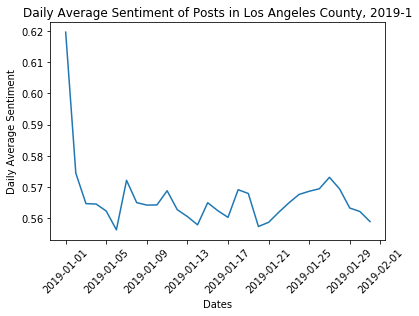

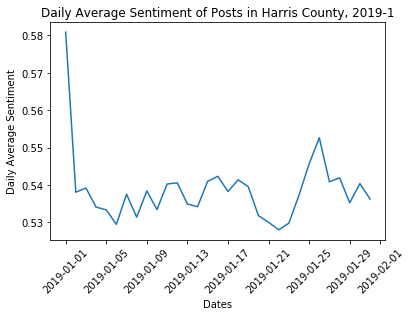

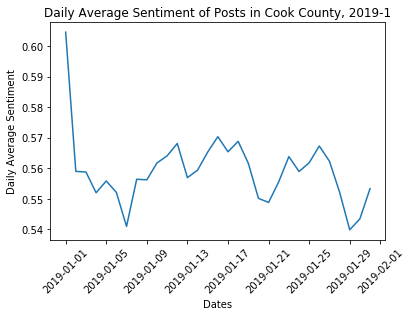

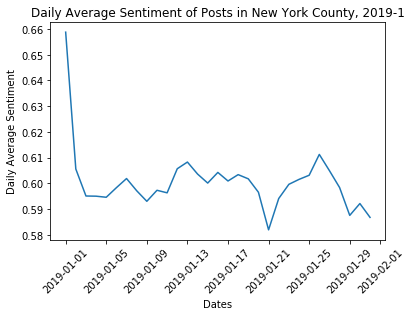

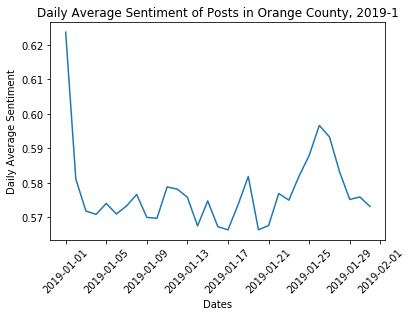

<Figure size 432x288 with 0 Axes>

In [32]:
for city in top_5_us_cities:
    df = pd.read_csv("".join(["../output/sentiment_graph_by_region/", city, "_2019_1.csv"]))
    base = date(2019, 1, 1)
    numdays = 31
    x = [base + timedelta(days=x) for x in range(numdays)]
    y = df["avg_sent_score"]

    plt.plot(x, y)
    
    plt.title("".join(["Daily Average Sentiment of Posts in ", city, " County, 2019-1"]))
    plt.xticks(rotation = 45)
    plt.xlabel("Dates")
    plt.ylabel("Daily Average Sentiment")
    # plt.legend(bbox_to_anchor=(1.6, 1.0), loc='upper right')

    plt.show()
    plt.savefig("".join(["../output/sentiment_graph_by_region/", city, "_2019_1_graph.png"]))